#### Ashley Chung Beng Hunn
# Group: The Swipers
# DISM/FT/3A/31

!pip install dask
!pip install dask-ml

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# get all the filename that contains training data and save into data_files
# save the filename that contains label into another variable
data_files = []
label_file = './data/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv'
for f in next(os.walk("./data/"))[2]:
    if f.endswith("csv") and f != label_file.split("/")[2]:
        data_files.append(f)

In [4]:
# read all the csv file in data_files and save into data list
_data = []
for file in data_files:
    df = pd.read_csv("./data/" + file)
    _data.append(df)
_data = pd.concat(_data)

In [5]:
# read the label_file and save into label variable
label = pd.read_csv(label_file)

In [6]:
_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16135561 entries, 0 to 1613561
Data columns (total 11 columns):
bookingID         int64
Accuracy          float64
Bearing           float64
acceleration_x    float64
acceleration_y    float64
acceleration_z    float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
second            float64
Speed             float64
dtypes: float64(10), int64(1)
memory usage: 1.4 GB


In [7]:
# Theres Negative Speed values which should not exist so we delete the rows with them,
# upon further investigation, these negative readings are recorded when the GPS accuracy was low

_data.describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
count,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07
mean,8.184819e+11,1.161035e+01,1.689684e+02,6.914529e-02,4.468976e+00,8.942974e-01,-1.710847e-03,2.800733e-04,-2.569688e-04,3.803484e+03,9.006543e+00
std,4.952476e+11,8.691672e+01,1.072966e+02,1.424161e+00,8.130664e+00,3.251549e+00,1.445619e-01,3.400630e-01,1.480824e-01,1.436686e+06,8.106415e+00
min,0.000000e+00,7.500000e-01,0.000000e+00,-7.841969e+01,-7.299412e+01,-7.844842e+01,-4.845575e+01,-7.488861e+01,-5.355445e+01,0.000000e+00,-2.000000e+00
25%,3.779571e+11,3.900000e+00,7.800000e+01,-5.081238e-01,-2.022476e+00,-9.316101e-01,-2.678888e-02,-2.993851e-02,-1.876500e-02,2.410000e+02,1.020000e+00
50%,8.074539e+11,4.250000e+00,1.688700e+02,6.137085e-02,9.081485e+00,7.757450e-01,-6.432411e-04,2.645046e-04,-3.542004e-05,5.200000e+02,7.530000e+00
75%,1.254130e+12,8.000000e+00,2.629840e+02,6.350620e-01,9.709778e+00,2.750938e+00,2.330639e-02,3.143085e-02,1.823425e-02,8.630000e+02,1.548000e+01
max,1.709397e+12,6.070101e+03,3.599995e+02,6.687346e+01,7.505589e+01,7.805576e+01,3.983975e+01,8.031496e+01,6.630078e+01,1.495797e+09,1.480186e+02


In [8]:
# Percentage of negative values 
print("Proportion of (-1 mps) out of all negative speed records", sum(_data.Speed == -1) / sum(_data.Speed < 0))

Proportion of (-1 mps) out of all negative speed records 0.9869793291650547


In [9]:
# Data Cleaning
# filter out GPS data with low accuracy and speed equals -1
# Besides, it was also observed that "-1" appeared most frequently among
# the negative records in speed. This may be an indication of the same error
# during data collection. To prevent our model from learning these noises
# in data, we will filter them out.
_data = _data.loc[(_data.Accuracy <= np.percentile(_data.Accuracy, 95)) & (_data.Speed != -1)]

In [10]:
# drop 'Accuracy' unecessary now
_data.drop(['Accuracy'], axis=1, inplace=True)

In [11]:
# from 16135561 entries to 15436836 entries and dropped accuracy and Bearing
_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15436836 entries, 0 to 1613561
Data columns (total 10 columns):
bookingID         int64
Bearing           float64
acceleration_x    float64
acceleration_y    float64
acceleration_z    float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
second            float64
Speed             float64
dtypes: float64(9), int64(1)
memory usage: 1.3 GB


In [12]:
_data['acceleration'] = np.sqrt((_data.loc[:, ('acceleration_x', 'acceleration_y', 'acceleration_z')] ** 2).sum(axis=1))

_data.drop(['acceleration_x', 'acceleration_y','acceleration_z'], axis=1, inplace=True)

In [13]:
_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15436836 entries, 0 to 1613561
Data columns (total 8 columns):
bookingID       int64
Bearing         float64
gyro_x          float64
gyro_y          float64
gyro_z          float64
second          float64
Speed           float64
acceleration    float64
dtypes: float64(7), int64(1)
memory usage: 1.0 GB


In [14]:
# PCA of Gyroscope Data
from sklearn.decomposition import PCA
pca_gyro = PCA(n_components=1).fit(_data.loc[:, ['gyro_x', 'gyro_y', 'gyro_z']])
pca_gyro.explained_variance_ratio_

# This shows that gyro_x explain the variations in gyroscope data fairly well (around 70%). 
# Thus, we will only keep the first component for modelling.

array([0.75860522])

In [15]:
# transform triaxial gyro readings into its first principal components
# need change gyro readings into 
_data['gyro'] = pca_gyro.transform(_data.loc[:, ('gyro_x', 'gyro_y', 'gyro_z')])
_data.drop(['gyro_x', 'gyro_y','gyro_z'], axis=1, inplace=True)

In [16]:
_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15436836 entries, 0 to 1613561
Data columns (total 6 columns):
bookingID       int64
Bearing         float64
second          float64
Speed           float64
acceleration    float64
gyro            float64
dtypes: float64(5), int64(1)
memory usage: 824.4 MB


In [17]:
data = pd.DataFrame()
for col in _data.columns:
    
    if col != "bookingID" and col != "label":
        temp = _data.groupby("bookingID")[col].agg(["mean", "sum", "max", "min"])
        data[col + "_mean"] = temp["mean"]
        data[col + "_sum"] = temp["sum"]
        data[col + "_max"] = temp["max"]
        data[col + "_min"] = temp["min"]

In [18]:
data = pd.merge(data, label, on="bookingID")
data.drop_duplicates(subset="bookingID", keep="last", inplace=True)
# remove bookingid data cleaning
data = data.drop(columns=["bookingID"]).reset_index(drop=True)

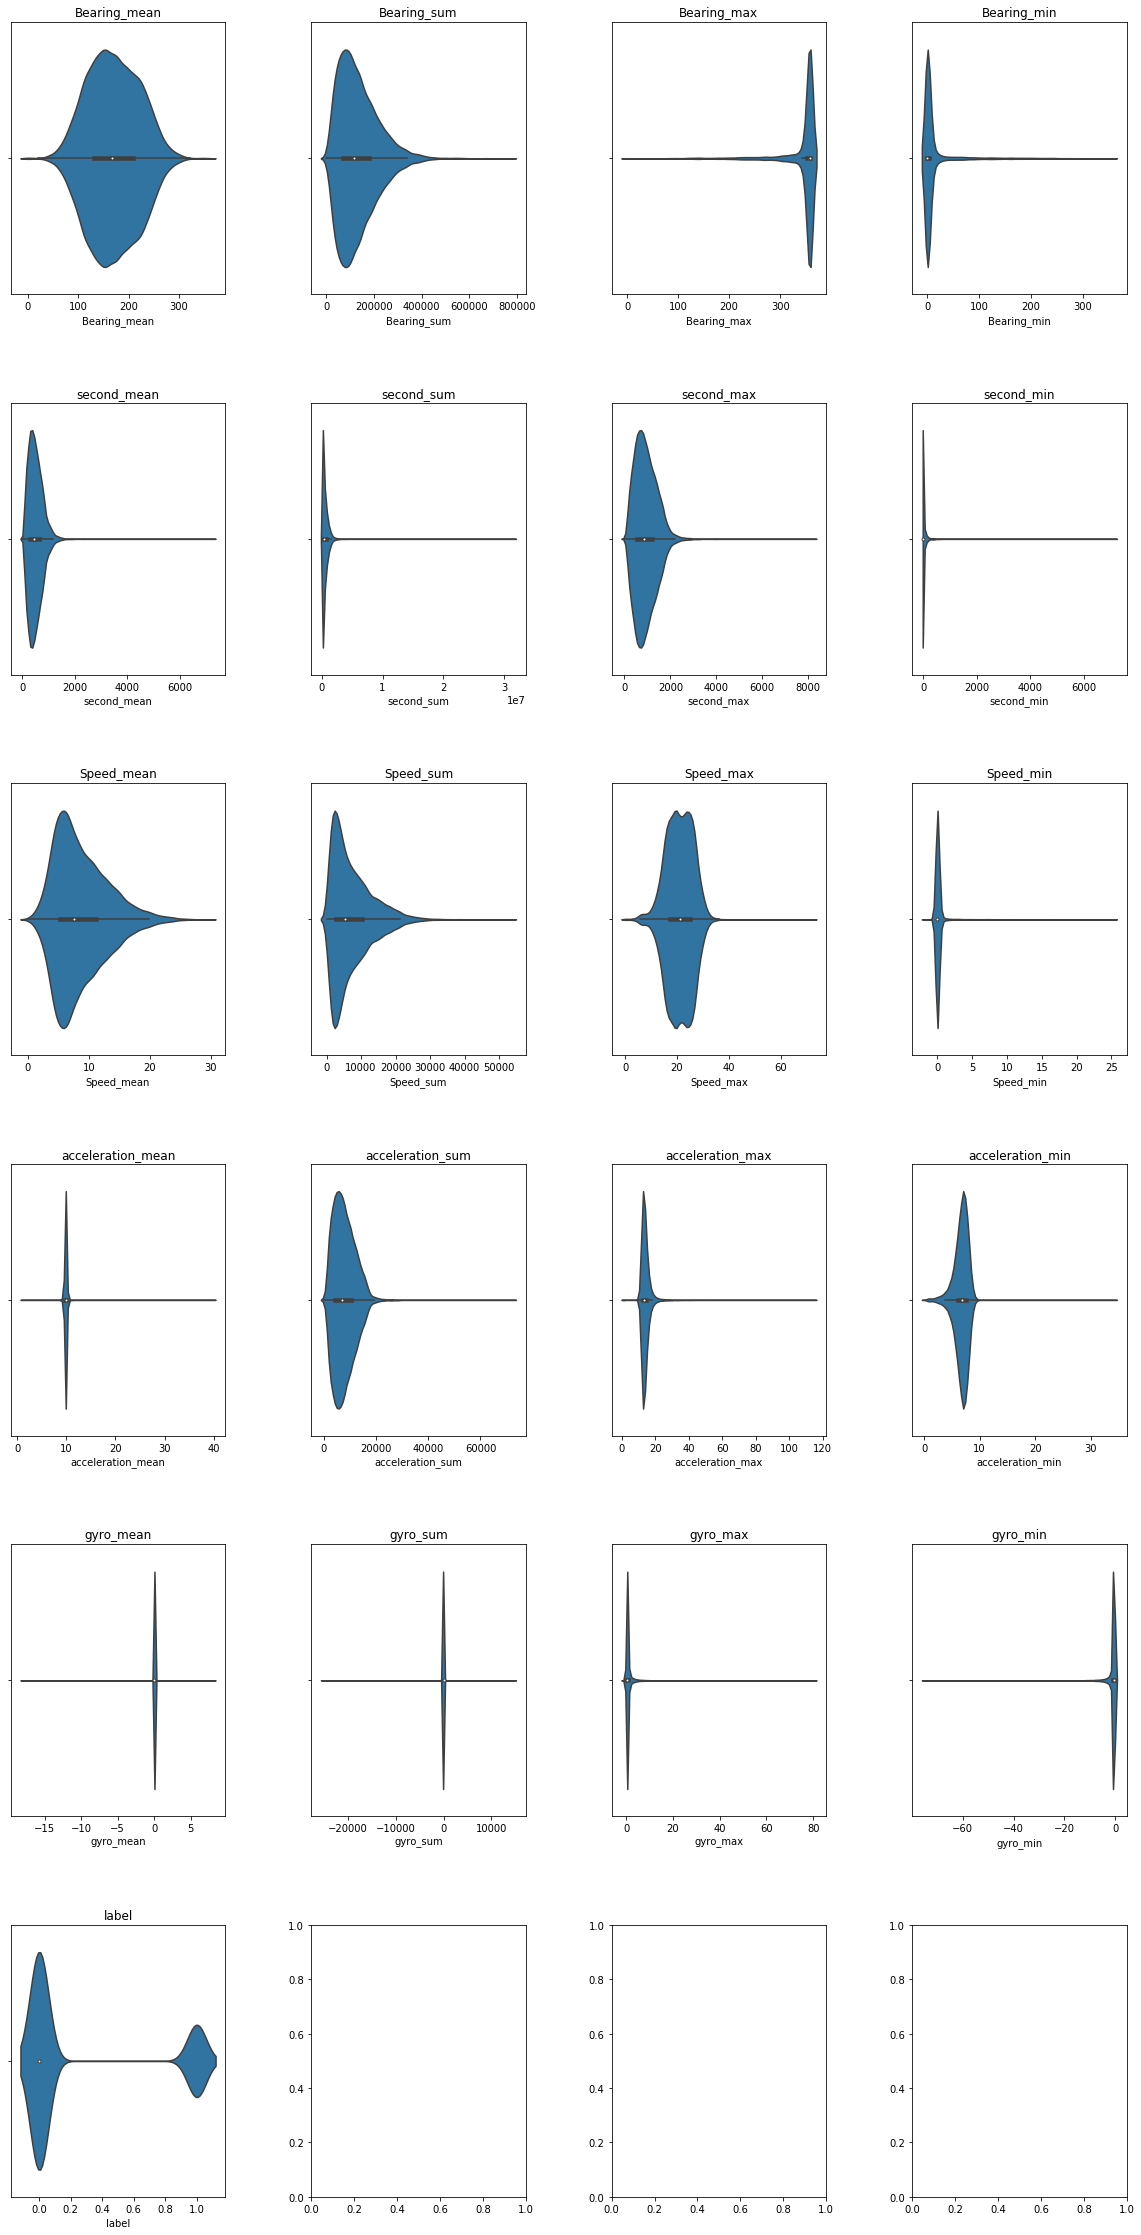

In [19]:
# this cell will take a bit of time (run with cautious)
fig, axes = plt.subplots(6, 4)
fig.set_figheight(40)
fig.set_figwidth(20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(data.columns)):
    row = i // 4
    column = i % 4
    sns.violinplot(data[data.columns[i]], ax=axes[row, column]).set_title("{}".format(data.columns[i]))

In [20]:
data[['Speed_min','second_min','acceleration_mean','gyro_mean','gyro_sum','gyro_max','gyro_min']]

,Speed_min,second_min,acceleration_mean,gyro_mean,gyro_sum,gyro_max,gyro_min
0,0.064309,0.0,9.883337,-0.006622,-6.635068,0.483789,-0.617390
1,0.000000,0.0,9.865608,-0.006898,-5.780290,0.465032,-0.658953
2,0.000000,0.0,9.929590,-0.012797,-2.495453,0.433957,-0.462342
3,0.000000,0.0,9.813434,0.022392,24.496557,0.654170,-0.512269
4,0.000000,0.0,9.918090,0.000434,0.475587,0.539171,-0.622260
...,...,...,...,...,...,...,...
19947,0.000000,0.0,11.371487,-0.007338,-7.154289,0.893600,-1.467946
19948,0.000000,0.0,9.876380,0.005550,4.068043,0.492377,-0.417494
19949,0.000000,0.0,9.723770,0.000423,0.330232,0.500215,-0.699710
19950,0.000000,0.0,9.779118,-0.000870,-0.920157,3.994458,-1.044173


In [21]:
data.drop(columns=["second_min"], inplace=True)

In [22]:
def calculate_std_upper_lower(data_series, std_multiplier=2):
    """
    Parameters
    ----------------------
    data_series : pandas.core.series.Series
        The data series that need to calculate the lower and upper bound
    std_multiplier : int
        The value that need to multiply the standard deviation
    
    Returns
    ----------------------
    tuple
        a tuple contains lower and upper bound of the data_series
    """
    mean, std = data_series.mean(), data_series.std()
    cut_off = std * std_multiplier
    lower, upper = mean - cut_off, mean + cut_off
    return (lower, upper)

In [23]:
sec_mean_lower, sec_mean_upper = calculate_std_upper_lower(data.second_mean)
sec_sum_lower, sec_sum_upper = calculate_std_upper_lower(data.second_sum)
sec_max_lower, sec_max_upper = calculate_std_upper_lower(data.second_max)

In [24]:
data = data.loc[(data.second_mean > sec_mean_lower) & (data.second_mean < sec_mean_upper)]
data = data.loc[(data.second_sum > sec_sum_lower) & (data.second_sum < sec_sum_upper)]
data = data.loc[(data.second_max > sec_max_lower) & (data.second_max < sec_max_upper)]

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19039 entries, 0 to 19951
Data columns (total 20 columns):
Bearing_mean         19039 non-null float64
Bearing_sum          19039 non-null float64
Bearing_max          19039 non-null float64
Bearing_min          19039 non-null float64
second_mean          19039 non-null float64
second_sum           19039 non-null float64
second_max           19039 non-null float64
Speed_mean           19039 non-null float64
Speed_sum            19039 non-null float64
Speed_max            19039 non-null float64
Speed_min            19039 non-null float64
acceleration_mean    19039 non-null float64
acceleration_sum     19039 non-null float64
acceleration_max     19039 non-null float64
acceleration_min     19039 non-null float64
gyro_mean            19039 non-null float64
gyro_sum             19039 non-null float64
gyro_max             19039 non-null float64
gyro_min             19039 non-null float64
label                19039 non-null int64
dtypes: float

In [26]:
# generate distance, velocity and angle features which is speed,acceleration ang gyro values * seconds respectively
for col in data.columns:
    if col.startswith("second"):
        agg_method = col.split("_")[1]
        data["distance_" + agg_method] = data[col] * data["Speed_" + agg_method]
        data["velocity_" + agg_method] = data[col] * data["acceleration_" + agg_method]
        data["angle_" + agg_method] = data[col] * data["gyro_" + agg_method]


In [27]:
data = data.drop(columns=['second_sum','second_mean']).reset_index(drop=True)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19039 entries, 0 to 19038
Data columns (total 27 columns):
Bearing_mean         19039 non-null float64
Bearing_sum          19039 non-null float64
Bearing_max          19039 non-null float64
Bearing_min          19039 non-null float64
second_max           19039 non-null float64
Speed_mean           19039 non-null float64
Speed_sum            19039 non-null float64
Speed_max            19039 non-null float64
Speed_min            19039 non-null float64
acceleration_mean    19039 non-null float64
acceleration_sum     19039 non-null float64
acceleration_max     19039 non-null float64
acceleration_min     19039 non-null float64
gyro_mean            19039 non-null float64
gyro_sum             19039 non-null float64
gyro_max             19039 non-null float64
gyro_min             19039 non-null float64
label                19039 non-null int64
distance_mean        19039 non-null float64
velocity_mean        19039 non-null float64
angle_mean   

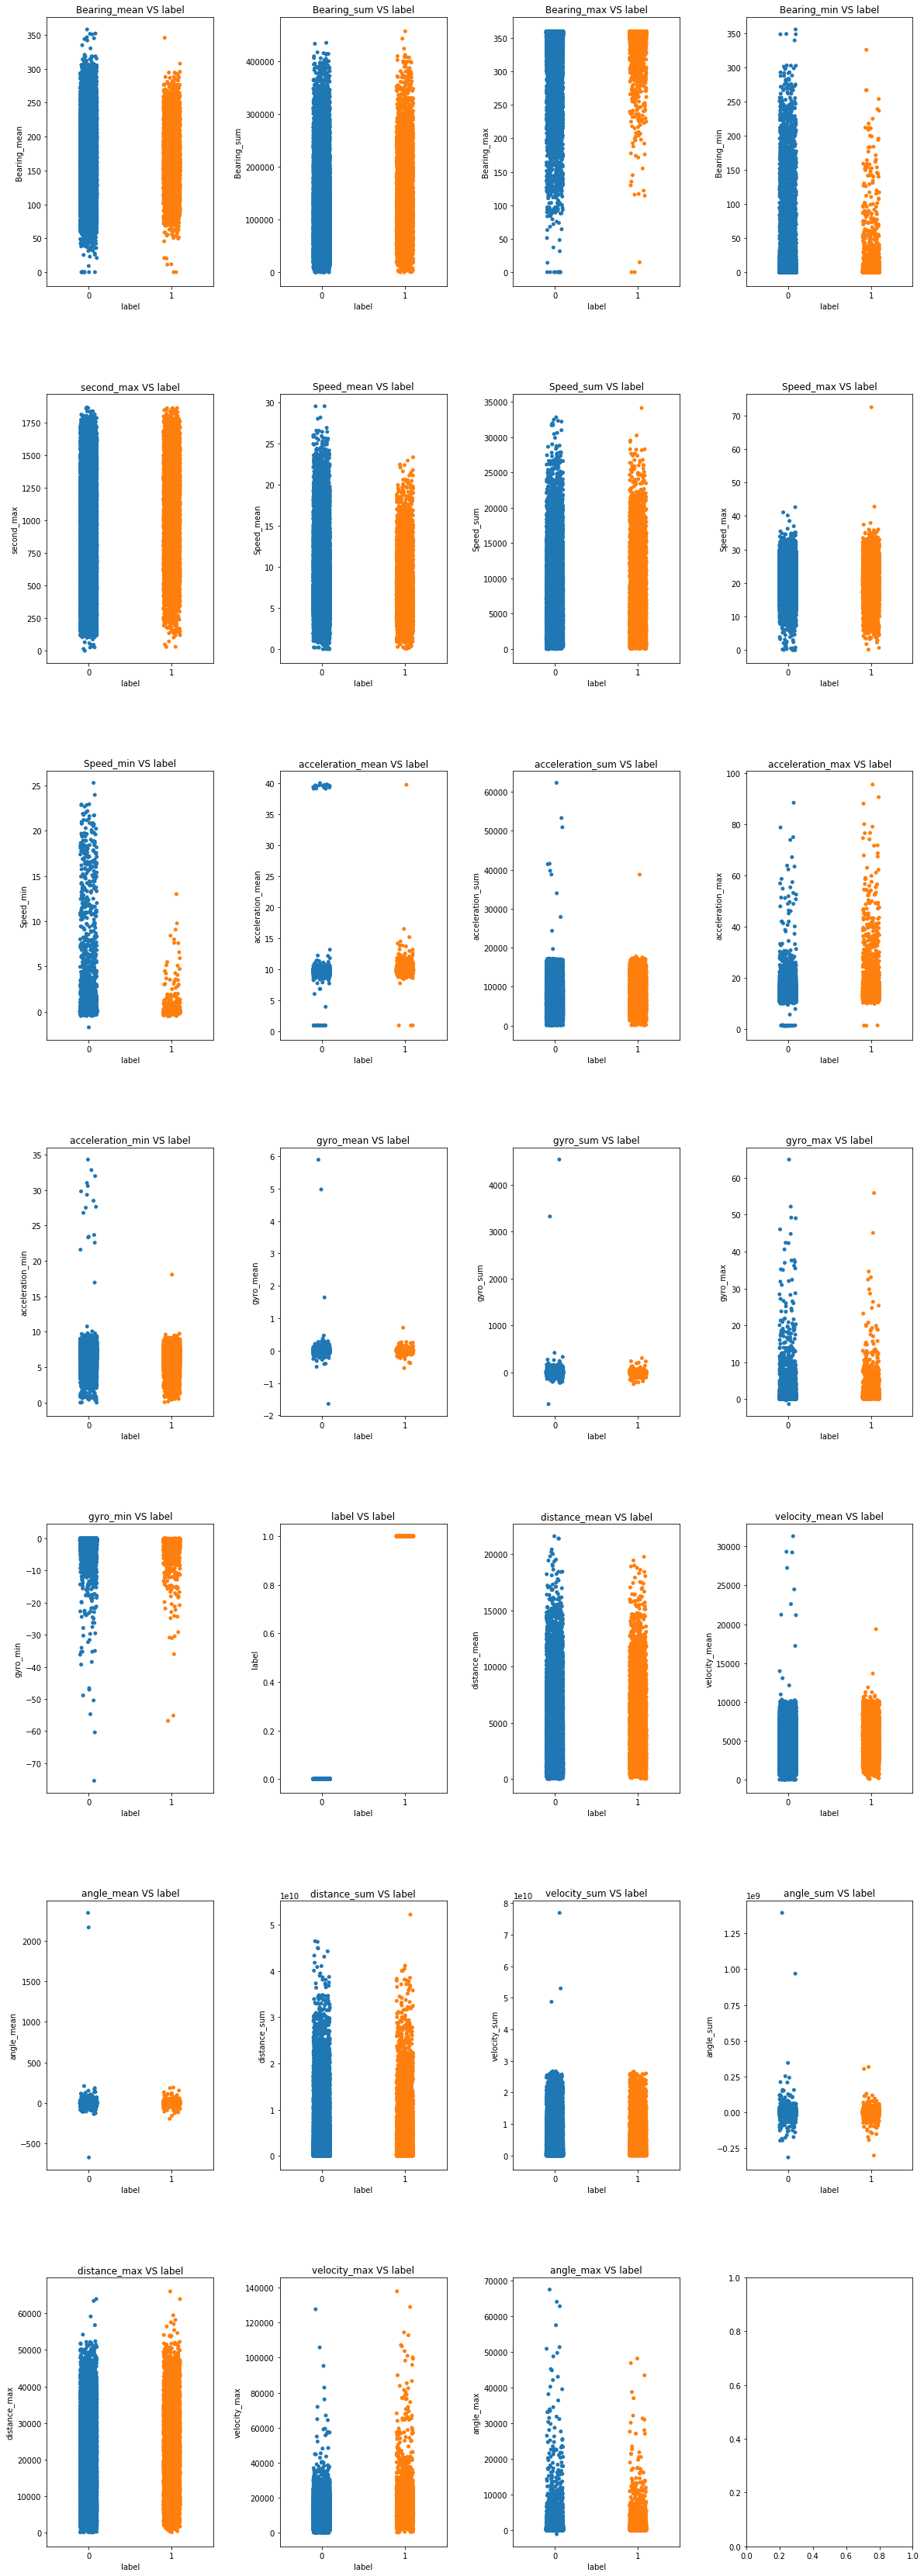

In [29]:
fig, axes = plt.subplots(7, 4)
fig.set_figheight(60)
fig.set_figwidth(20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(data.columns)):
    row = i // 4
    column = i % 4
    sns.stripplot(x="label", y=data.columns[i], data=data, ax=axes[row, column]).set_title("{} VS label".format(data.columns[i]))

In [30]:
# data = data[['Bearing_max', 'second_max', 'Speed_max', 'Speed_mean','distance_max','velocity_max','velocity_mean','Speed_min','angle_max','label']]

In [31]:
# data_majority = data[data["label"] == 0]
# data_minority = data[data["label"] == 1]

In [32]:
# data_minority_upsampled = resample(data_minority,replace=True,n_samples=data_majority.count()[0],random_state=42)
# data_grouped = pd.concat([data_majority, data_minority_upsampled])

# upsampling will increase roc by 3% to 73, but it will decrease accuracy score to 53%

In [33]:
X = data.drop(columns=["label"]).reset_index(drop=True)
y = data.label.reset_index(drop=True)

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

clf = GradientBoostingRegressor()

kf = StratifiedKFold(n_splits=5, random_state=99)
# smote = SMOTE(random_state=99)

cv_scores = []
#     with parallel_backend("dask"):
for _, (train_index, test_index) in enumerate(kf.split(X, y)):
    train_X, train_y = X.loc[train_index], y[train_index] 
    # up sampling the train data
#             train_X, train_y = smote.fit_sample(train_X, train_y)
    test_X, test_y = X.loc[test_index], y[test_index]

    clf.fit(train_X, train_y)
    y_pred = clf.predict(test_X)
    score = roc_auc_score(test_y, y_pred)
    cv_scores.append(score)
    
CV5score = np.mean(cv_scores)
print("5 Fold Average " + str(CV5score))

5 Fold Average 0.6987960812672429


In [36]:
#check for feature importance

importances = pd.DataFrame({'feature':train_X.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# This shows which columns play a bigger impact
importances.head(40)

,importance
feature,
velocity_mean,0.170
Speed_mean,0.157
angle_max,0.141
velocity_max,0.089
Speed_sum,0.085
Speed_max,0.062
acceleration_min,0.034
second_max,0.032
Bearing_max,0.024


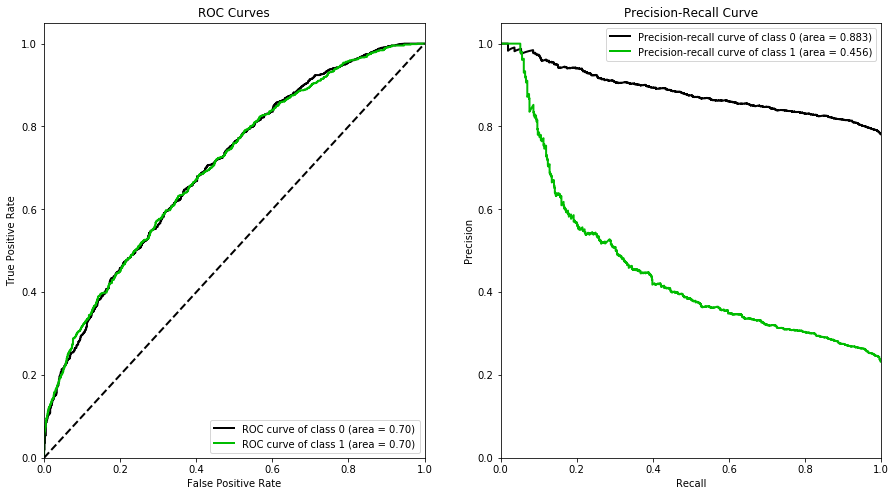

In [37]:
import scikitplot as skplt

from sklearn.metrics import classification_report, accuracy_score

fig, axes = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(15)
skplt.metrics.plot_roc(test_y, np.column_stack((1-y_pred, y_pred)), plot_macro=False, plot_micro=False, ax=axes[0])
skplt.metrics.plot_precision_recall(test_y, np.column_stack((1-y_pred, y_pred)), plot_micro=False, ax=axes[1])

In [38]:
y_result = np.where(y_pred > 0.8, 1, 0)
print(classification_report(test_y, y_result))
print("Accuracy Score:", accuracy_score(test_y, y_result))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      2937
           1       1.00      0.05      0.09       870

    accuracy                           0.78      3807
   macro avg       0.89      0.52      0.48      3807
weighted avg       0.83      0.78      0.70      3807

Accuracy Score: 0.7822432361439453


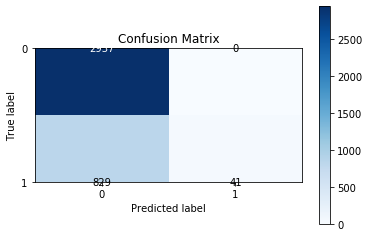

In [39]:
skplt.metrics.plot_confusion_matrix(test_y, y_result)

In [40]:
# Hyper Tuning the Model

In [53]:
gb_result = {}
gb_result["learning_rate"] = {"parameter": np.arange(0.01, 0.20, 0.05), "train_result": [], "test_result": []}
gb_result["n_estimators"] = {"parameter": np.arange(30, 200, 20), "train_result": [], "test_result": []}
gb_result["max_depth"] = {"parameter": np.linspace(3, 20, 10), "train_result": [], "test_result": []}
gb_result["min_samples_split"] = {"parameter": np.linspace(0.1, 1.0, 10), "train_result": [], "test_result": []}
gb_result["min_samples_leaf"] = {"parameter": np.linspace(0.1, 0.5, 10), "train_result": [], "test_result": []}
gb_result["max_features"] = {"parameter": np.arange(1, len(X.columns)+1), "train_result": [], "test_result": []}

for k in gb_result.keys():
    for param in gb_result[k]["parameter"]:
        if k == "learning_rate":
            clf = GradientBoostingRegressor(learning_rate=param)
        elif k == "n_estimators":
            clf = GradientBoostingRegressor(n_estimators=param)
        elif k == "max_depth":
            clf = GradientBoostingRegressor(max_depth=param)
        elif k == "min_samples_split":
            clf = GradientBoostingRegressor(min_samples_split=param)
        elif k == "min_samples_leaf":
            clf = GradientBoostingRegressor(min_samples_leaf=param)
        elif k == "max_features":
            clf = GradientBoostingRegressor(max_features=param)
        else:
            clf = GradientBoostingRegressor()
        clf.fit(train_X.loc[:, X.columns], train_y)
        train_score = roc_auc_score(train_y, clf.predict(train_X.loc[:, X.columns]))
        test_score = roc_auc_score(test_y, clf.predict(test_X.loc[:, X.columns]))
        gb_result[k]["train_result"].append(train_score)
        gb_result[k]["test_result"].append(test_score)

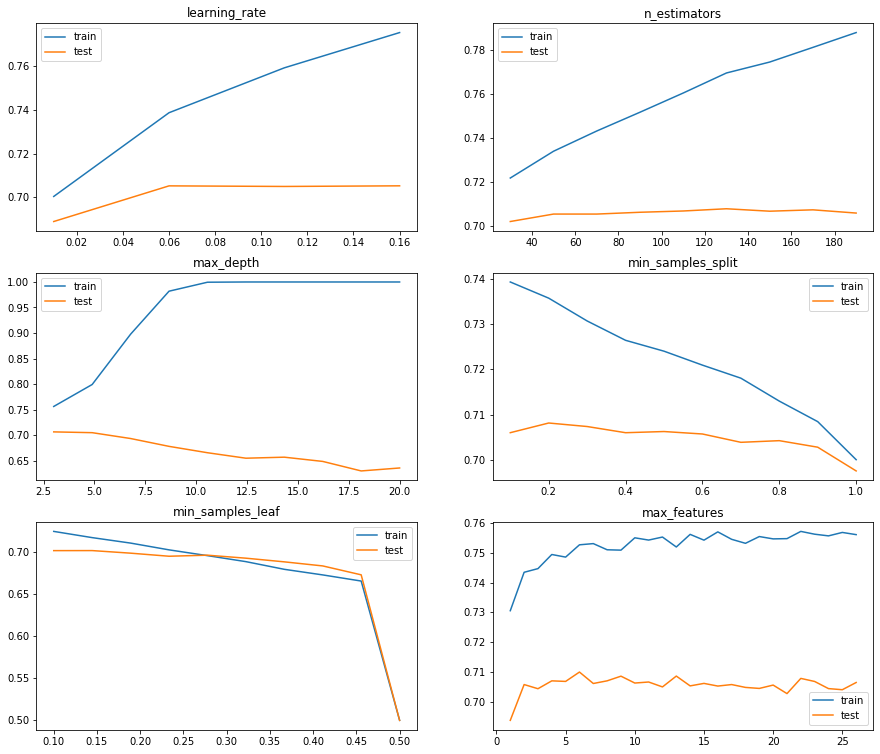

In [54]:
fig, axes = plt.subplots(3, 2)
fig.set_figheight(13)
fig.set_figwidth(15)

count = 0
for k in gb_result.keys():
    row = count // 2
    column = count % 2
    sns.lineplot(gb_result[k]["parameter"], gb_result[k]["train_result"], ax=axes[row, column], label="train")
    sns.lineplot(gb_result[k]["parameter"], gb_result[k]["test_result"], ax=axes[row, column], label="test")
    axes[row, column].set_title(k)
    count += 1

In [57]:
from dask_ml.model_selection import GridSearchCV
# run with cautious (take long time)
gb_parameters = {
    "learning_rate": np.arange(0.01, 0.20, 0.05),
    "n_estimators": np.arange(30, 200, 20),
    "max_features": np.arange(1, len(X.columns)+1)
}
_gb = GradientBoostingRegressor()
_gb_cv_clf = GridSearchCV(_gb, gb_parameters, cv=kf, scoring="roc_auc")
_gb_cv_clf.fit(X.loc[:, X.columns], y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=99, shuffle=False),
             estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': array([0.01, 0.06, 0.11, 0.16]),
                         'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26]),
                         'n_estimators': array([ 30,  50,  70,  90, 110, 130, 150, 170, 190])},
             scoring='roc_auc')

In [58]:
_gb_cv_clf.best_params_

{'learning_rate': 0.060000000000000005, 'max_features': 8, 'n_estimators': 190}

In [41]:
kf = StratifiedKFold(n_splits=5, random_state=99)
# smote = SMOTE(random_state=99)

def get_cv_score(clf, X, y, kf):
    cv_scores = []
    for _, (train_index, test_index) in enumerate(kf.split(X, y)):
        train_X, train_y = X.loc[train_index], y[train_index] 
        # up sampling the train data
#             train_X, train_y = smote.fit_sample(train_X, train_y)
        test_X, test_y = X.loc[test_index], y[test_index]

        clf.fit(train_X, train_y)
        y_pred = clf.predict(test_X)
        score = roc_auc_score(test_y, y_pred)
        cv_scores.append(score)
    return np.mean(cv_scores)

In [61]:
get_cv_score(_gb_cv_clf.best_estimator_, X.loc[:, X.columns], y, kf)

0.7003468187670274

In [65]:
_gb_cv_clf

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=99, shuffle=False),
             estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': array([0.01, 0.06, 0.11, 0.16]),
                         'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26]),
                         'n_estimators': array([ 30,  50,  70,  90, 110, 130, 150, 170, 190])},
             scoring='roc_auc')

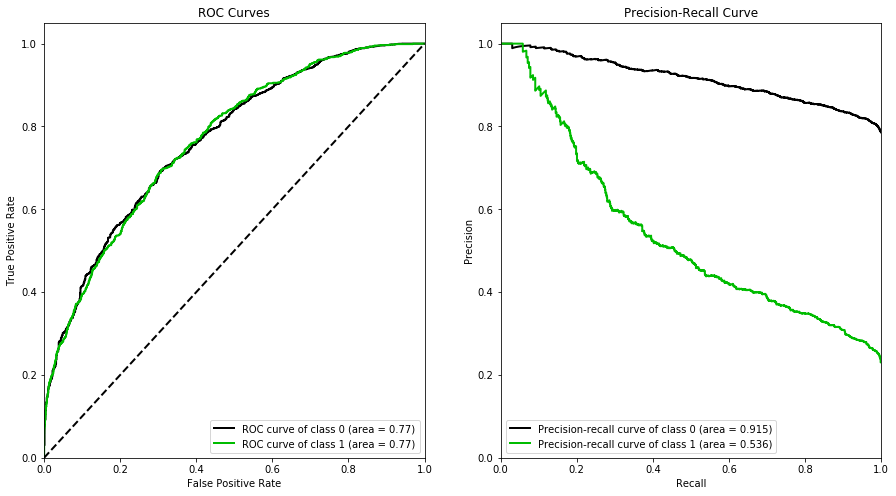

In [39]:
import scikitplot as skplt

from sklearn.metrics import classification_report, accuracy_score

fig, axes = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(15)
skplt.metrics.plot_roc(test_y, np.column_stack((1-y_pred, y_pred)), plot_macro=False, plot_micro=False, ax=axes[0])
skplt.metrics.plot_precision_recall(test_y, np.column_stack((1-y_pred, y_pred)), plot_micro=False, ax=axes[1])

In [40]:
y_result = np.where(y_pred > 0.8, 1, 0)
print(classification_report(test_y, y_result))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      2951
           1       1.00      0.05      0.10       857

    accuracy                           0.79      3808
   macro avg       0.89      0.53      0.49      3808
weighted avg       0.83      0.79      0.70      3808



In [42]:
print("Accuracy Score:", accuracy_score(test_y, y_result))

Accuracy Score: 0.7865021008403361


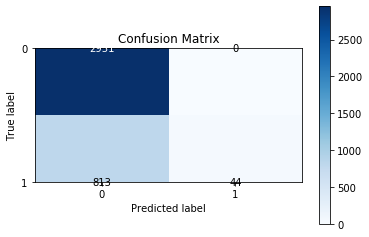

In [41]:
skplt.metrics.plot_confusion_matrix(test_y, y_result)

In [67]:
from joblib import dump
_gb_cv_clf.fit(train_X, train_y)
dump(_gb_cv_clf, "./model/GBR.joblib")

['./model/GBR.joblib']

In [ ]:
# The End